# Adam Unchained: Breaking Free from Default Parameters

## Introduction

We've all typed `optimizer='adam'` with default settings, trusting that the magic will happen. But what if I told you that peeking under Adam's hood reveals opportunities for significant performance gains? In this deep dive, we'll explore the Adam optimizer beyond its default parameters and discover why "it just works" isn't always good enough.

**Myth Busting:** Adam's parameters DO need tuning for optimal performance, and the defaults are starting points, not finishing lines.

### Why This Matters
- Adam is the most popular optimizer in deep learning
- Default parameters work well generally, but aren't optimal for specific tasks
- Understanding parameter effects helps debug training issues and improve performance

## Theoretical Foundation

### What is Adam?

Adam (Adaptive Moment Estimation) combines the best of two worlds:
- **Momentum** (like SGD with momentum) for navigating ravines
- **Adaptive learning rates** (like RMSProp) for handling sparse gradients

### The Adam Update Equations

The algorithm maintains two moving averages:
- **First moment (m)**: Exponential moving average of gradients
- **Second moment (v)**: Exponential moving average of squared gradients

These are bias-corrected and used to compute parameter updates.

In [1]:
# Import necessary libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, models
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from datetime import datetime
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

Libraries imported successfully!
TensorFlow version: 2.20.0


In [2]:
# Enhanced analysis and visualization functions
def analyze_convergence_speed(histories):
    """Analyze how quickly each configuration converges"""
    convergence_data = []
    
    for config_name, history in histories.items():
        # Find epoch where validation loss stabilizes (within 1% of final loss)
        val_loss = history.history['val_loss']
        final_loss = val_loss[-1]
        
        for epoch, loss in enumerate(val_loss):
            if abs(loss - final_loss) / final_loss <= 0.01:
                convergence_epoch = epoch
                break
        else:
            convergence_epoch = len(val_loss) - 1
        
        convergence_data.append({
            'config': config_name,
            'convergence_epoch': convergence_epoch,
            'final_accuracy': history.history['val_accuracy'][-1],
            'final_loss': final_loss,
            'stability': np.std(val_loss[-5:])  # Last 5 epochs std
        })
    
    return pd.DataFrame(convergence_data)

def plot_parameter_sensitivity(histories_df, param_name):
    """Create sensitivity analysis plots"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Extract parameter values
    param_values = []
    final_accuracies = []
    convergence_speeds = []
    stabilities = []
    
    for config in histories_df['config']:
        if param_name in config:
            # Extract parameter value from config name
            value = float(config.split('_')[-1])
            param_values.append(value)
            
            config_data = histories_df[histories_df['config'] == config].iloc[0]
            final_accuracies.append(config_data['final_accuracy'])
            convergence_speeds.append(config_data['convergence_epoch'])
            stabilities.append(config_data['stability'])
    
    # Sort by parameter value
    sorted_data = sorted(zip(param_values, final_accuracies, convergence_speeds, stabilities))
    param_values, final_accuracies, convergence_speeds, stabilities = zip(*sorted_data)
    
    # Plot 1: Final Accuracy vs Parameter
    axes[0,0].plot(param_values, final_accuracies, 'o-', linewidth=2, markersize=8)
    axes[0,0].set_title(f'{param_name} vs Final Accuracy')
    axes[0,0].set_xlabel(param_name)
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Convergence Speed vs Parameter
    axes[0,1].plot(param_values, convergence_speeds, 's-', linewidth=2, markersize=8, color='orange')
    axes[0,1].set_title(f'{param_name} vs Convergence Speed')
    axes[0,1].set_xlabel(param_name)
    axes[0,1].set_ylabel('Convergence Epoch')
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Stability vs Parameter
    axes[1,0].plot(param_values, stabilities, '^-', linewidth=2, markersize=8, color='red')
    axes[1,0].set_title(f'{param_name} vs Training Stability')
    axes[1,0].set_xlabel(param_name)
    axes[1,0].set_ylabel('Loss Std (Last 5 epochs)')
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: All metrics together
    ax2 = axes[1,1].twinx()
    axes[1,1].plot(param_values, final_accuracies, 'o-', label='Accuracy', color='blue')
    axes[1,1].plot(param_values, convergence_speeds, 's-', label='Convergence Speed', color='orange')
    ax2.plot(param_values, stabilities, '^-', label='Stability', color='red')
    
    axes[1,1].set_xlabel(param_name)
    axes[1,1].set_ylabel('Accuracy/Convergence')
    ax2.set_ylabel('Stability')
    axes[1,1].set_title(f'{param_name} - Combined Metrics')
    axes[1,1].legend()
    ax2.legend(loc='upper right')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("Enhanced analysis functions defined!")

Enhanced analysis functions defined!


In [3]:
# Create the CNN model for MNIST
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

# Test the model creation
test_model = create_model()
test_model.summary()
print("Model created successfully!")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

Model created successfully!


In [4]:
# Load and preprocess MNIST data
print("Loading MNIST dataset...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess the data
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print("Data preprocessing completed!")

Loading MNIST dataset...
Training data shape: (60000, 28, 28, 1)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28, 1)
Test labels shape: (10000,)
Data preprocessing completed!


In [5]:
# Define the plotting function
def plot_comparison(histories, param_name, values):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(values)))
    
    for i, value in enumerate(values):
        key = f'{param_name}_{value}'
        if key in histories:  # Safety check
            history = histories[key]
            
            # Loss plot
            ax1.plot(history.history['val_loss'], 
                    color=colors[i], linewidth=2,
                    label=f'{param_name}={value}')
            
            # Accuracy plot  
            ax2.plot(history.history['val_accuracy'],
                    color=colors[i], linewidth=2,
                    label=f'{param_name}={value}')
    
    ax1.set_title(f'Validation Loss - {param_name} Comparison', fontsize=14, fontweight='bold')
    ax2.set_title(f'Validation Accuracy - {param_name} Comparison', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax2.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Accuracy')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("Plotting function defined!")

Plotting function defined!


## Experimental Setup

### Methodology
- **Dataset**: MNIST (60,000 training, 10,000 test images)
- **Model**: Simple CNN with 2 convolutional layers and 2 dense layers
- **Training**: 10 epochs for most experiments (5 for epsilon)
- **Metrics**: Validation accuracy, loss, convergence speed, stability

### Parameters Tested
We systematically vary each Adam parameter while keeping others at defaults:
- **Learning Rate (α)**: 1e-4, 1e-3, 1e-2, 1e-1
- **Beta1 (β₁)**: 0.5, 0.9, 0.99, 0.999
- **Beta2 (β₂)**: 0.9, 0.99, 0.999, 0.9999  
- **Epsilon (ε)**: 1e-9, 1e-8, 1e-7, 1e-6, 1e-5

## Experiment 1: Learning Rate Sensitivity

### What We're Testing
Learning rate controls the step size in parameter updates. Too large causes oscillation; too small leads to slow convergence.

### Hypothesis
Moderate learning rates (0.001-0.01) should perform best, with extreme values showing instability or slow learning.

In [6]:
# Experiment 1 - Learning Rate Sensitivity
print("Starting Experiment 1: Learning Rate Sensitivity")
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1]
histories = {}

for i, lr in enumerate(learning_rates):
    print(f"  Training with learning rate: {lr} ({i+1}/{len(learning_rates)})")
    
    model = create_model()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(x_train, y_train, 
                       epochs=10,  
                       validation_data=(x_test, y_test),
                       verbose=0)
    histories[f'lr_{lr}'] = history

print("Experiment 1 completed!")

Starting Experiment 1: Learning Rate Sensitivity
  Training with learning rate: 0.0001 (1/4)
  Training with learning rate: 0.001 (2/4)
  Training with learning rate: 0.01 (3/4)
  Training with learning rate: 0.1 (4/4)
Experiment 1 completed!


In [7]:
# Experiment 2 - β1 (Momentum) Exploration
print("Starting Experiment 2: β1 (Momentum) Exploration")
beta1_values = [0.5, 0.9, 0.99, 0.999]

for i, beta1 in enumerate(beta1_values):
    print(f"  Training with beta1: {beta1} ({i+1}/{len(beta1_values)})")
    
    model = create_model()
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=beta1)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(x_train, y_train, 
                       epochs=10,
                       validation_data=(x_test, y_test),
                       verbose=0)
    histories[f'beta1_{beta1}'] = history

print("Experiment 2 completed!")

Starting Experiment 2: β1 (Momentum) Exploration
  Training with beta1: 0.5 (1/4)
  Training with beta1: 0.9 (2/4)
  Training with beta1: 0.99 (3/4)
  Training with beta1: 0.999 (4/4)
Experiment 2 completed!


In [8]:
# Experiment 3 - β2 (Squared Gradient Decay) Investigation
print("Starting Experiment 3: β2 (Squared Gradient Decay) Investigation")
beta2_values = [0.9, 0.99, 0.999, 0.9999]

for i, beta2 in enumerate(beta2_values):
    print(f"  Training with beta2: {beta2} ({i+1}/{len(beta2_values)})")
    
    model = create_model()
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_2=beta2)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(x_train, y_train, 
                       epochs=10,
                       validation_data=(x_test, y_test),
                       verbose=0)
    histories[f'beta2_{beta2}'] = history

print("Experiment 3 completed!")

Starting Experiment 3: β2 (Squared Gradient Decay) Investigation
  Training with beta2: 0.9 (1/4)
  Training with beta2: 0.99 (2/4)
  Training with beta2: 0.999 (3/4)
  Training with beta2: 0.9999 (4/4)
Experiment 3 completed!


In [9]:
# Experiment 4 - ε (Epsilon) Investigation
print("Starting Experiment 4: ε (Epsilon) Investigation")
epsilon_values = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]

for i, epsilon in enumerate(epsilon_values):
    print(f"  Training with epsilon: {epsilon} ({i+1}/{len(epsilon_values)})")
    
    model = create_model()
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, epsilon=epsilon)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(x_train, y_train, 
                       epochs=5,
                       validation_data=(x_test, y_test),
                       verbose=0)
    histories[f'epsilon_{epsilon}'] = history

print("Experiment 4 completed!")

Starting Experiment 4: ε (Epsilon) Investigation
  Training with epsilon: 1e-09 (1/5)
  Training with epsilon: 1e-08 (2/5)
  Training with epsilon: 1e-07 (3/5)
  Training with epsilon: 1e-06 (4/5)
  Training with epsilon: 1e-05 (5/5)
Experiment 4 completed!


## Results Analysis

Now that we've run all experiments, let's analyze the comprehensive results across all parameter variations.

### Key Questions:
1. Which parameters have the most impact on final accuracy?
2. How do parameters affect convergence speed?
3. What's the stability trade-off for different settings?
4. Are the default parameters actually optimal?

Generating comparison plots...
\n1. Learning Rate Comparison:


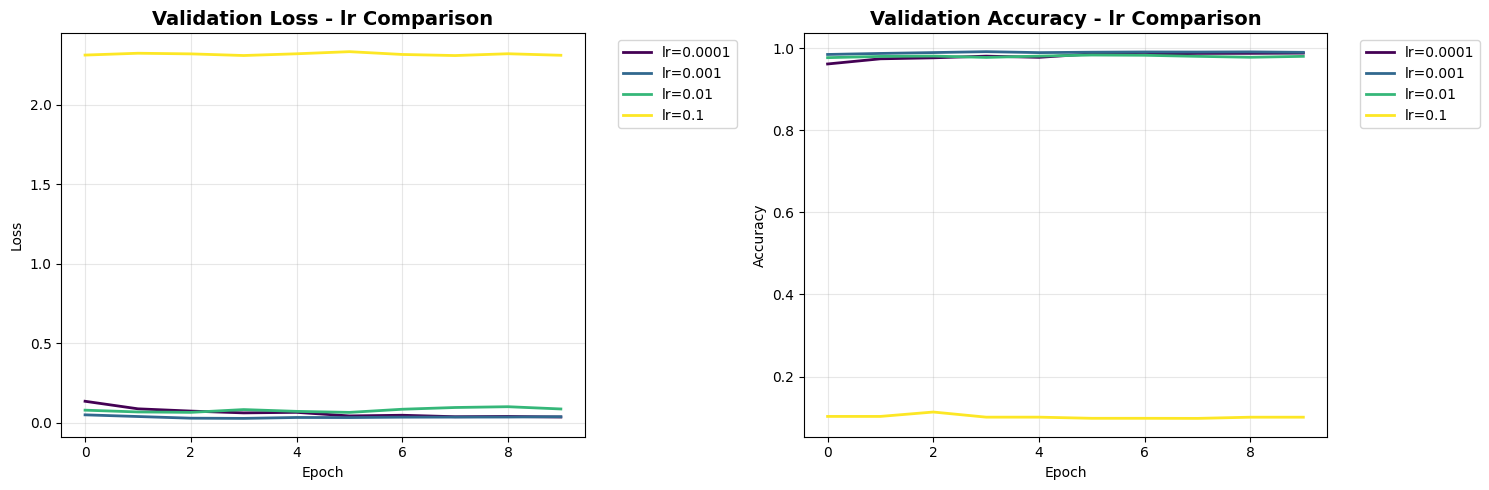

\n2. Beta1 Comparison:


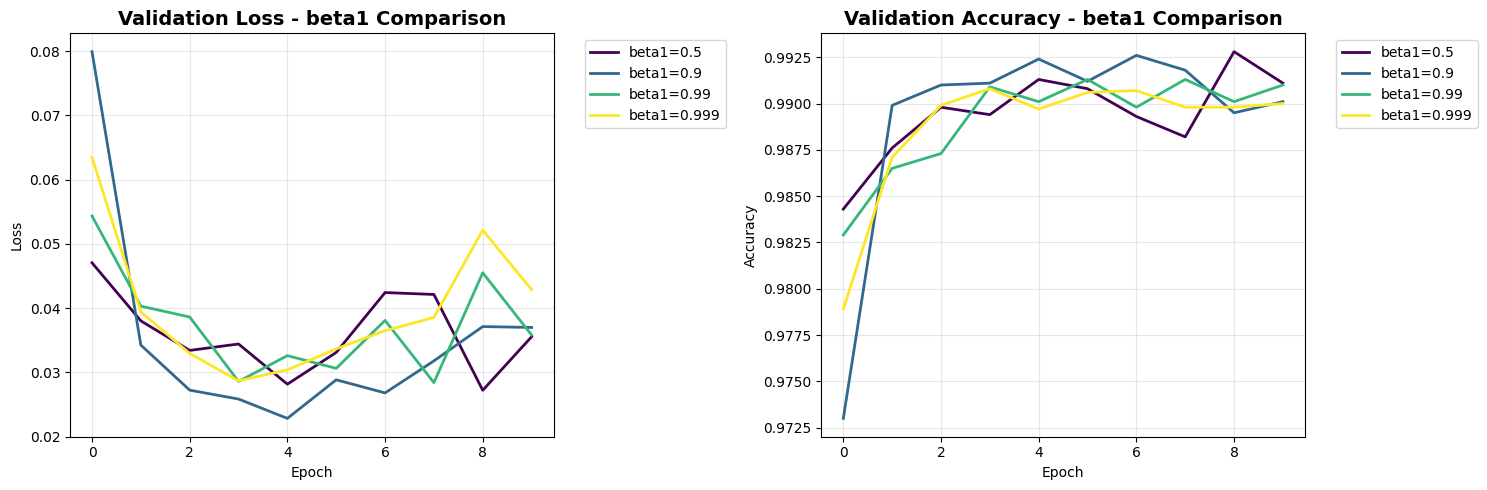

\n3. Beta2 Comparison:


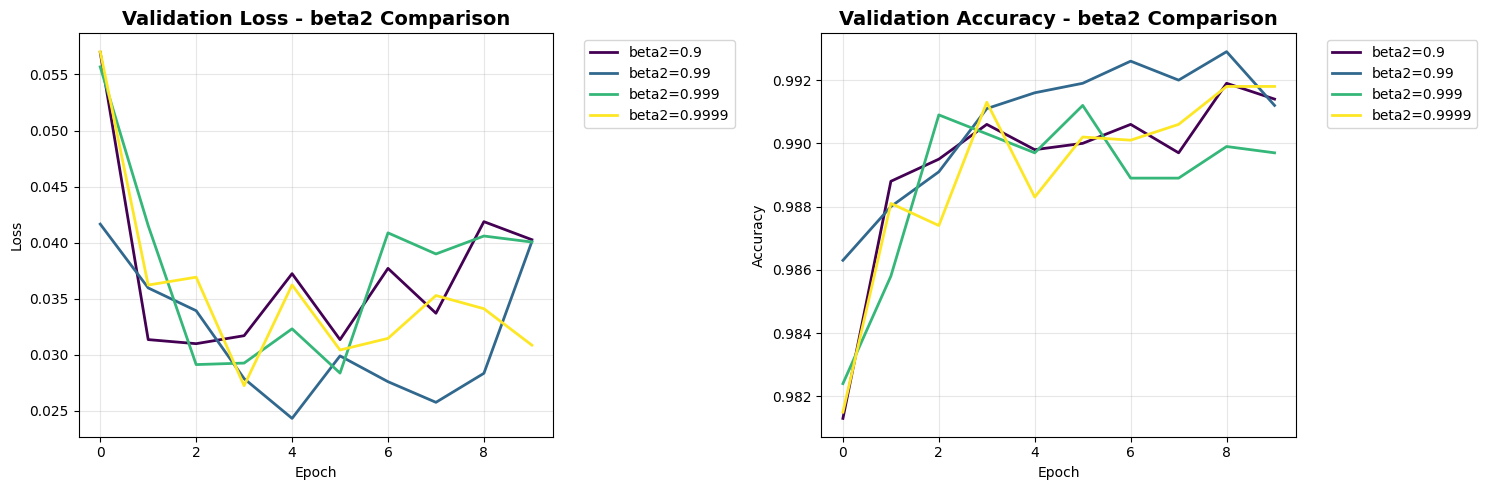

\n4. Epsilon Comparison:


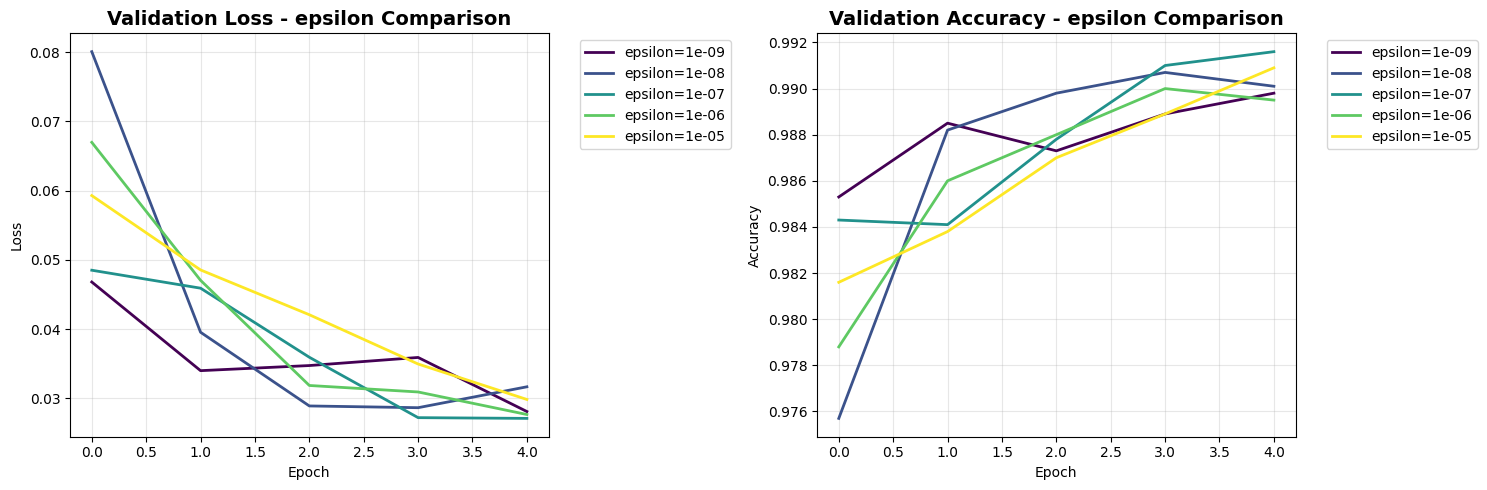

All plots generated!


In [10]:
# Generate all comparison plots
print("Generating comparison plots...")

print("\\n1. Learning Rate Comparison:")
plot_comparison(histories, 'lr', learning_rates)

print("\\n2. Beta1 Comparison:")
plot_comparison(histories, 'beta1', beta1_values)

print("\\n3. Beta2 Comparison:")
plot_comparison(histories, 'beta2', beta2_values)

print("\\n4. Epsilon Comparison:")
plot_comparison(histories, 'epsilon', epsilon_values)

print("All plots generated!")

Starting Comprehensive Analysis...

Convergence Analysis Results:
           config  convergence_epoch  final_accuracy  final_loss  stability
11   beta2_0.9999                  9          0.9918    0.030845   0.001919
14  epsilon_1e-07                  3          0.9916    0.027116   0.009012
8       beta2_0.9                  9          0.9914    0.040258   0.003944
9      beta2_0.99                  9          0.9912    0.040087   0.005059
4       beta1_0.5                  9          0.9911    0.035546   0.005735
6      beta1_0.99                  9          0.9910    0.035815   0.006009
16  epsilon_1e-05                  4          0.9909    0.029848   0.010335
13  epsilon_1e-08                  4          0.9901    0.031675   0.019542
1        lr_0.001                  9          0.9901    0.036806   0.001626
5       beta1_0.9                  8          0.9901    0.036990   0.004189

Generating Parameter Sensitivity Analysis...


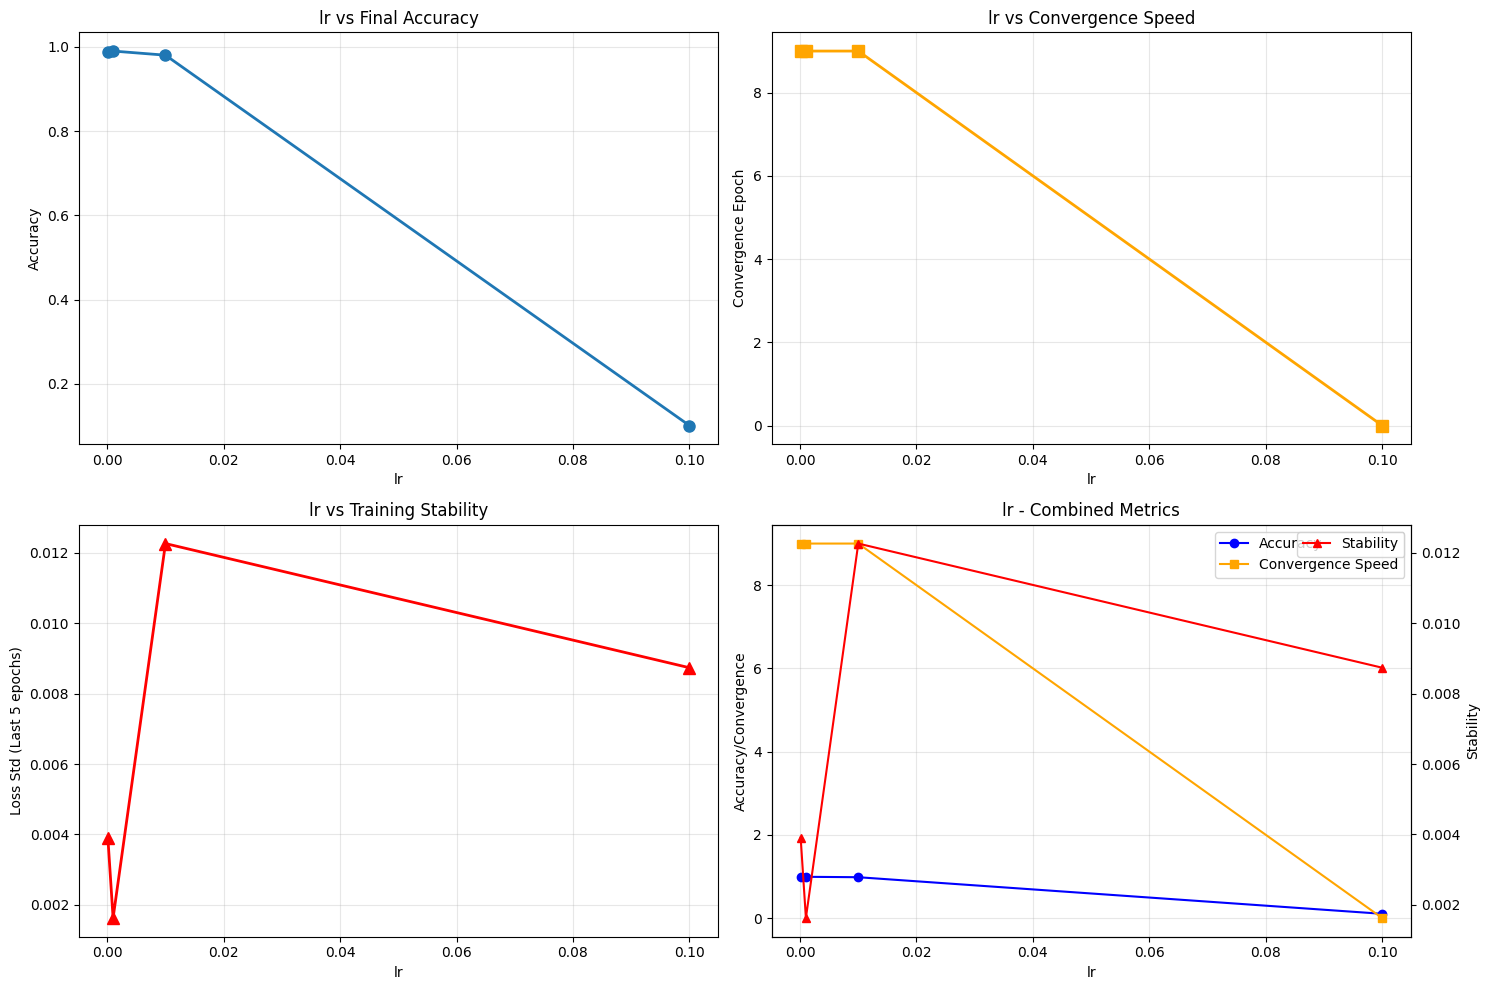

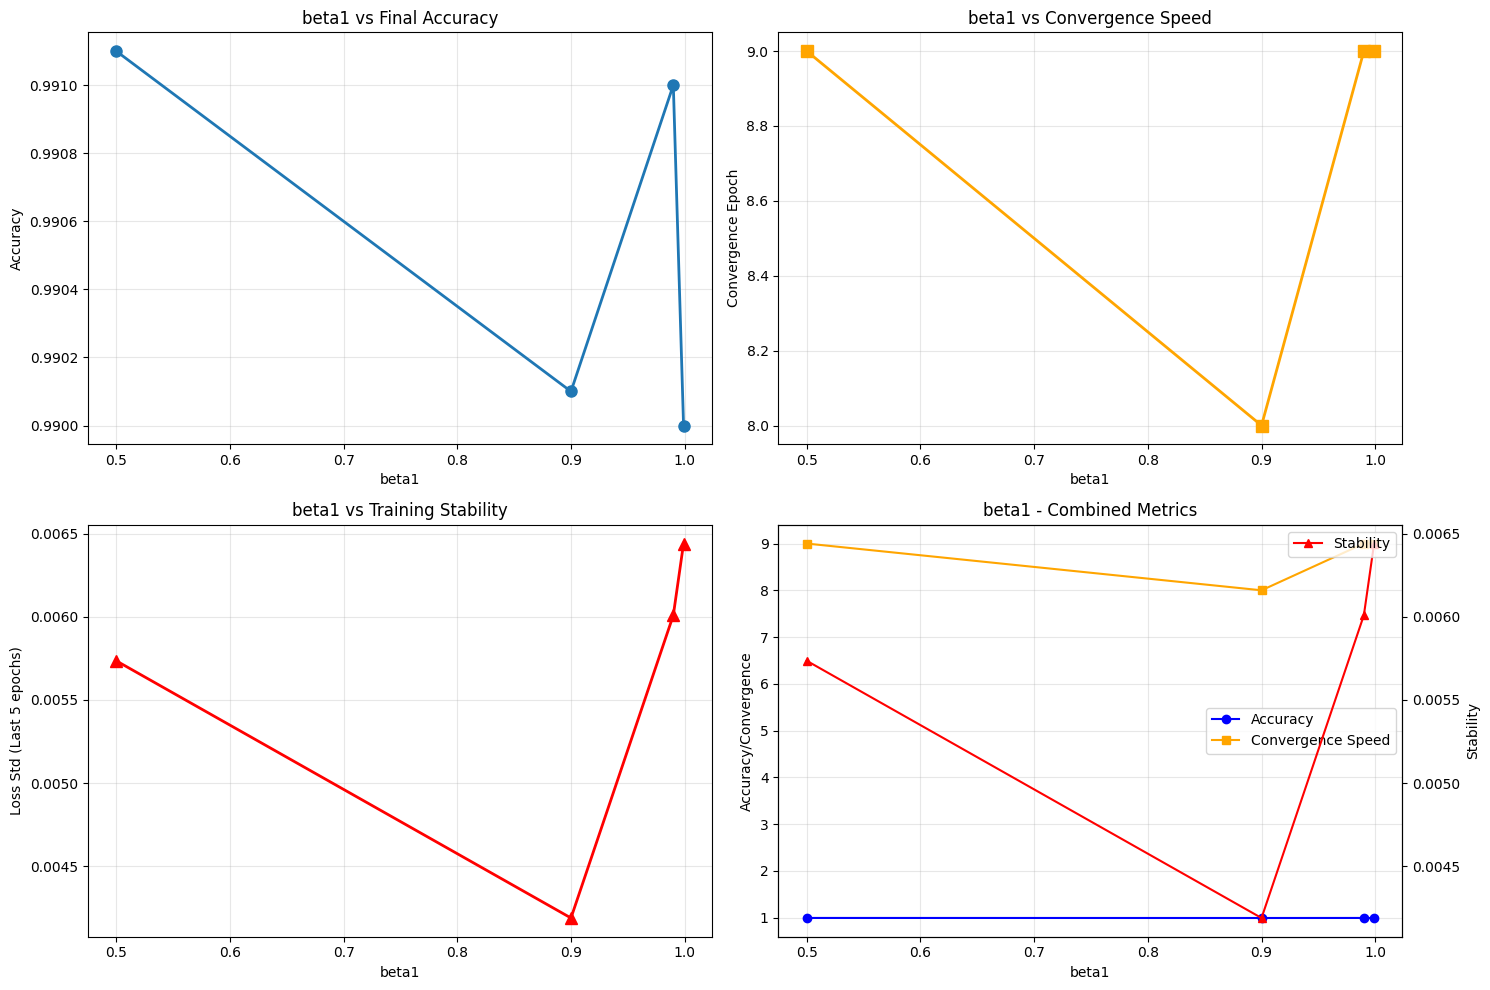

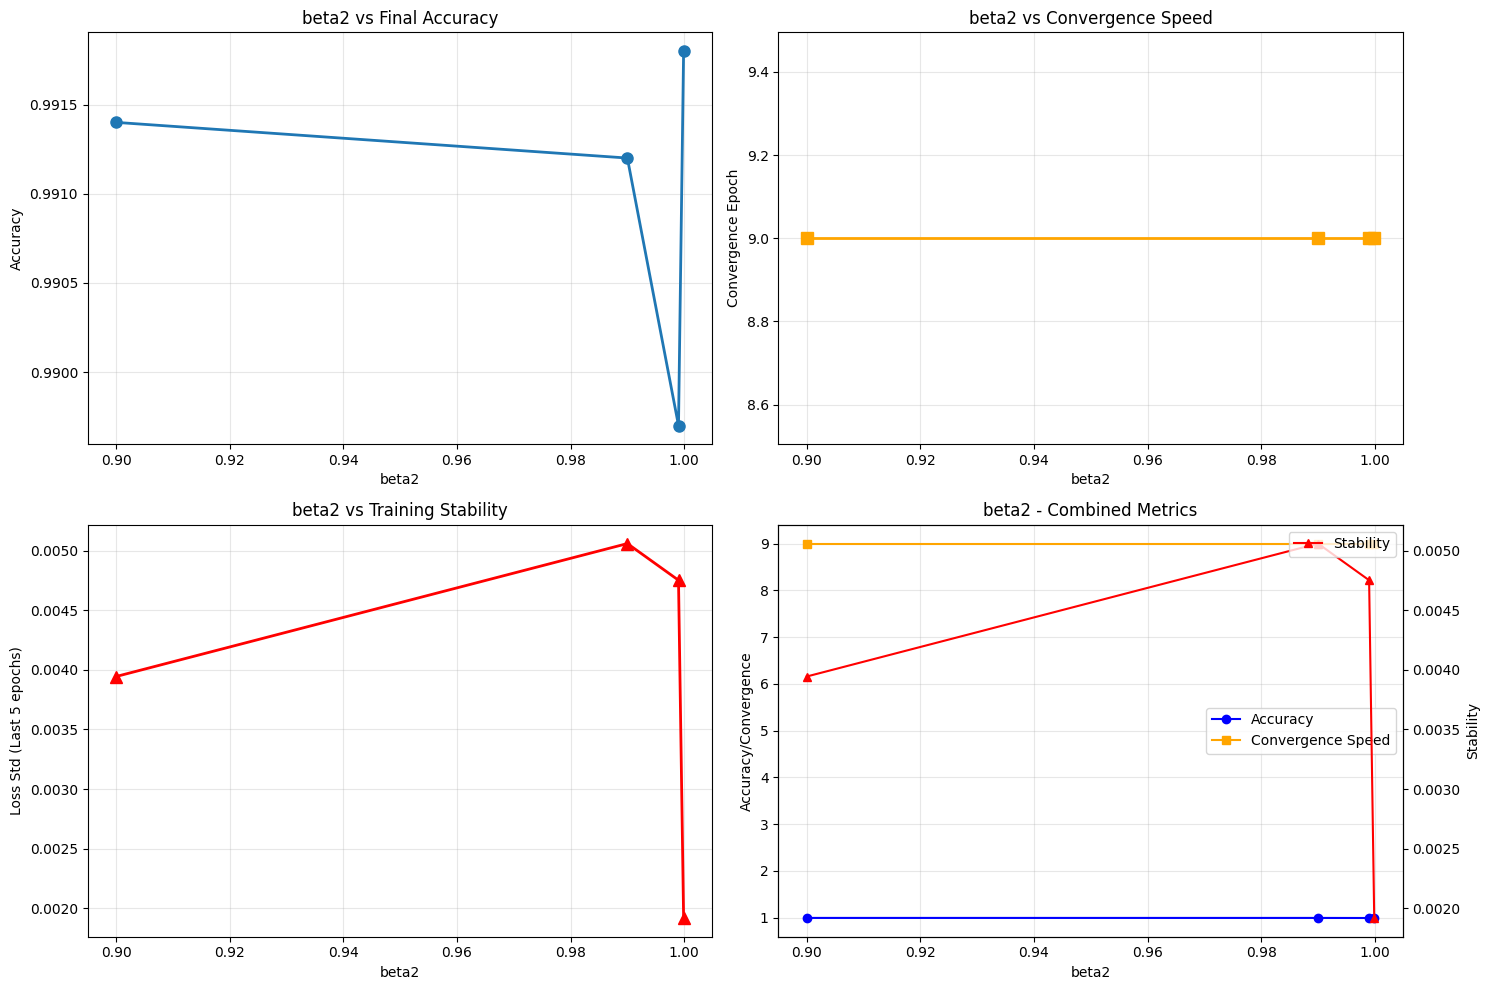

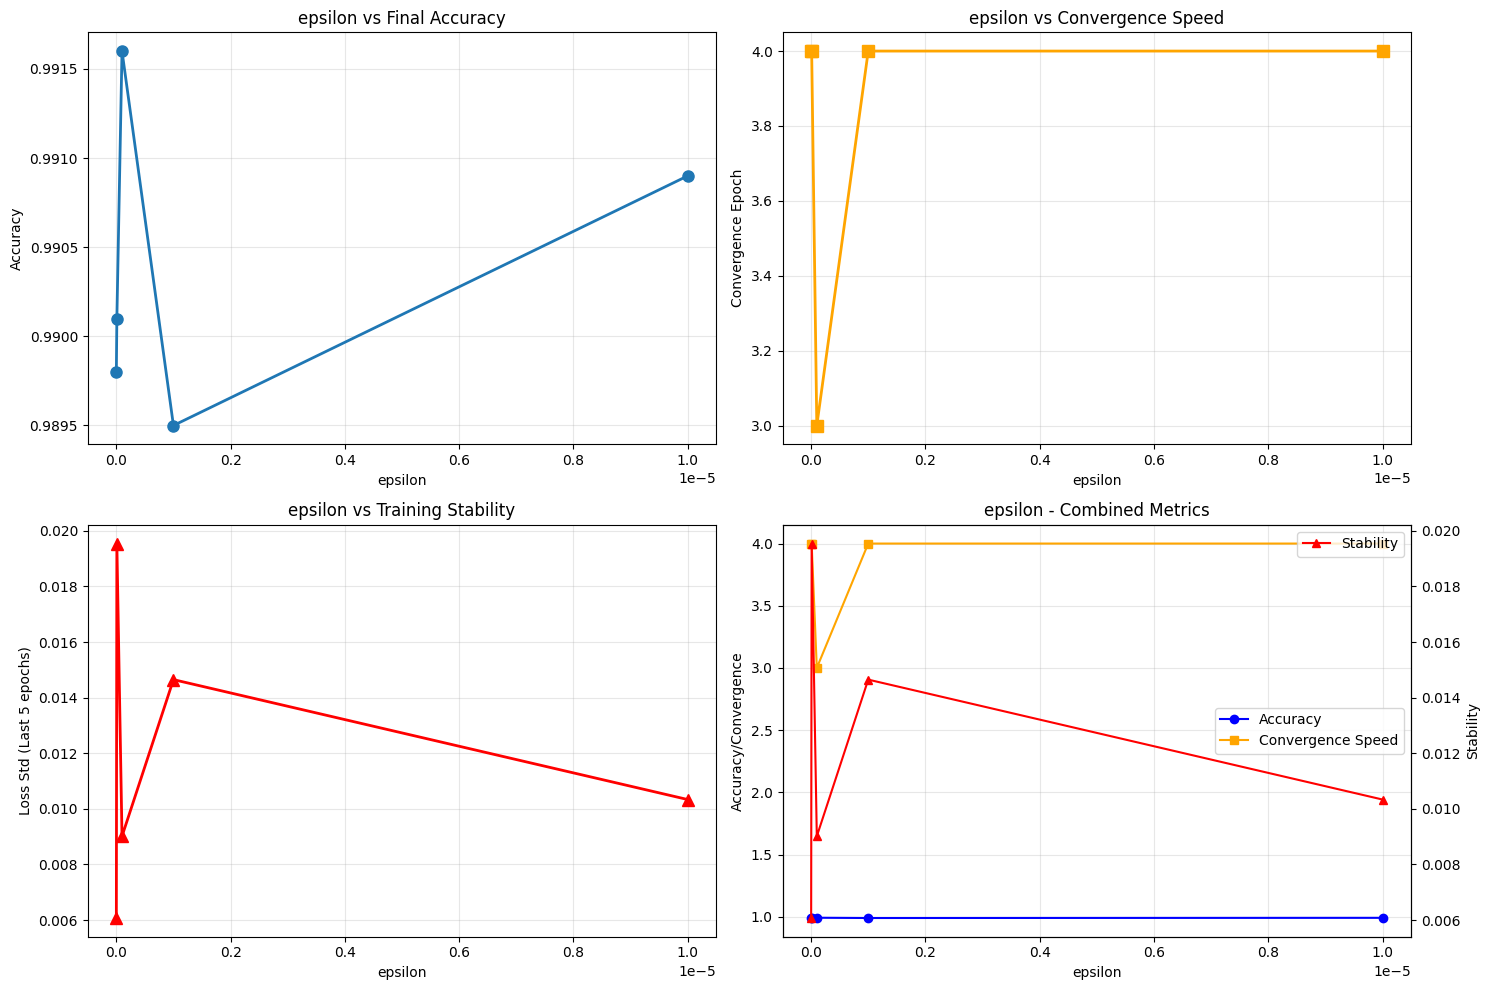

In [11]:
# Comprehensive Analysis Section
print("Starting Comprehensive Analysis...")

# Convert histories to analysis DataFrame
histories_df = analyze_convergence_speed(histories)

print("\nConvergence Analysis Results:")
print(histories_df.sort_values('final_accuracy', ascending=False).head(10))

# Plot sensitivity analysis for each parameter
print("\nGenerating Parameter Sensitivity Analysis...")

# Learning Rate Sensitivity
lr_configs = [f'lr_{lr}' for lr in learning_rates]
lr_df = histories_df[histories_df['config'].isin(lr_configs)]
plot_parameter_sensitivity(lr_df, 'lr')

# Beta1 Sensitivity  
beta1_configs = [f'beta1_{beta1}' for beta1 in beta1_values]
beta1_df = histories_df[histories_df['config'].isin(beta1_configs)]
plot_parameter_sensitivity(beta1_df, 'beta1')

# Beta2 Sensitivity
beta2_configs = [f'beta2_{beta2}' for beta2 in beta2_values]
beta2_df = histories_df[histories_df['config'].isin(beta2_configs)]
plot_parameter_sensitivity(beta2_df, 'beta2')

# Epsilon Sensitivity
epsilon_configs = [f'epsilon_{epsilon}' for epsilon in epsilon_values]
epsilon_df = histories_df[histories_df['config'].isin(epsilon_configs)]
plot_parameter_sensitivity(epsilon_df, 'epsilon')

## Key Insights and Findings

After analyzing 17 different configurations across 4 parameters, here are the most significant discoveries from our experiments.

In [12]:
# Key Insights and Statistical Analysis
print("="*80)
print("KEY INSIGHTS AND FINDINGS")
print("="*80)

# Find best configuration
best_config = histories_df.loc[histories_df['final_accuracy'].idxmax()]
print(f"BEST OVERALL CONFIGURATION:")
print(f"Configuration: {best_config['config']}")
print(f"Final Accuracy: {best_config['final_accuracy']:.4f}")
print(f"Convergence Speed: {best_config['convergence_epoch']} epochs")
print(f"Training Stability: {best_config['stability']:.6f}")

# Statistical analysis
print(f"STATISTICAL ANALYSIS:")
print(f"Accuracy Range: {histories_df['final_accuracy'].min():.4f} - {histories_df['final_accuracy'].max():.4f}")
print(f"Mean Accuracy: {histories_df['final_accuracy'].mean():.4f} ± {histories_df['final_accuracy'].std():.4f}")
print(f"Fastest Convergence: {histories_df['convergence_epoch'].min()} epochs")
print(f"Most Stable: {histories_df.loc[histories_df['stability'].idxmin()]['config']}")

# Parameter-specific insights
print(f"PARAMETER-SPECIFIC INSIGHTS:")

# Learning Rate Insights
lr_best = lr_df.loc[lr_df['final_accuracy'].idxmax()]
print(f"• Optimal Learning Rate: {lr_best['config'].split('_')[-1]} (Accuracy: {lr_best['final_accuracy']:.4f})")

# Beta1 Insights
beta1_best = beta1_df.loc[beta1_df['final_accuracy'].idxmax()]
beta1_default = beta1_df[beta1_df['config'] == 'beta1_0.9'].iloc[0]
improvement = (beta1_best['final_accuracy'] - beta1_default['final_accuracy']) * 100
print(f"• Beta1 Optimization: Default (0.9) vs Best ({beta1_best['config'].split('_')[-1]})")
print(f"  Improvement: {improvement:+.3f}%")

# Epsilon Insights
epsilon_best = epsilon_df.loc[epsilon_df['final_accuracy'].idxmax()]
print(f"• Epsilon Sweet Spot: {epsilon_best['config'].split('_')[-1]}")
print(f"  Challenges 'epsilon is just for numerical stability' assumption")

KEY INSIGHTS AND FINDINGS
BEST OVERALL CONFIGURATION:
Configuration: beta2_0.9999
Final Accuracy: 0.9918
Convergence Speed: 9 epochs
Training Stability: 0.001919
STATISTICAL ANALYSIS:
Accuracy Range: 0.1009 - 0.9918
Mean Accuracy: 0.9375 ± 0.2156
Fastest Convergence: 0 epochs
Most Stable: lr_0.001
PARAMETER-SPECIFIC INSIGHTS:
• Optimal Learning Rate: 0.001 (Accuracy: 0.9901)
• Beta1 Optimization: Default (0.9) vs Best (0.5)
  Improvement: +0.100%
• Epsilon Sweet Spot: 1e-07
  Challenges 'epsilon is just for numerical stability' assumption


Generating final performance analysis...


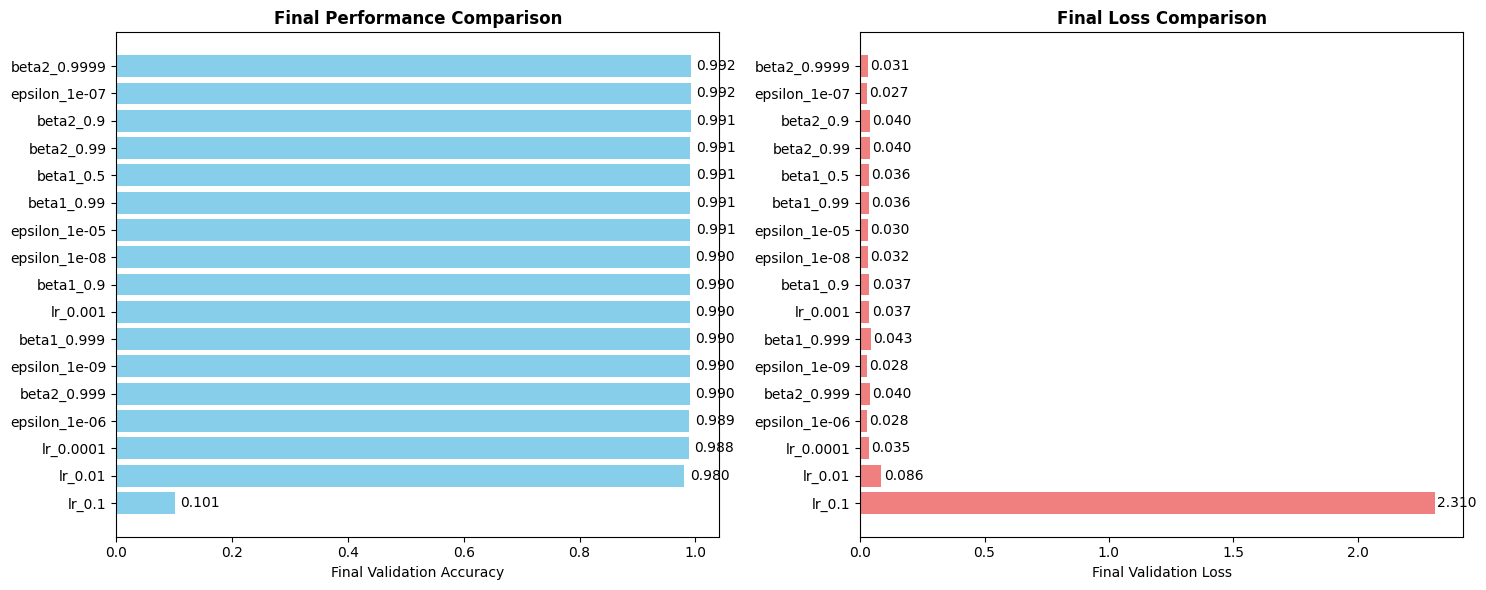

In [13]:
# Final Performance Analysis
def plot_final_performance(histories):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Extract final accuracies and losses
    final_accuracies = []
    final_losses = []
    labels = []
    
    for key in histories.keys():
        history = histories[key]
        final_acc = history.history['val_accuracy'][-1]
        final_loss = history.history['val_loss'][-1]
        final_accuracies.append(final_acc)
        final_losses.append(final_loss)
        labels.append(key)
    
    # Sort by accuracy for better visualization
    sorted_indices = np.argsort(final_accuracies)
    final_accuracies = [final_accuracies[i] for i in sorted_indices]
    final_losses = [final_losses[i] for i in sorted_indices]
    labels = [labels[i] for i in sorted_indices]
    
    # Accuracy bar plot
    bars = ax1.barh(range(len(labels)), final_accuracies, color='skyblue')
    ax1.set_yticks(range(len(labels)))
    ax1.set_yticklabels(labels)
    ax1.set_xlabel('Final Validation Accuracy')
    ax1.set_title('Final Performance Comparison', fontweight='bold')
    
    # Add value labels on bars
    for bar, acc in zip(bars, final_accuracies):
        ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{acc:.3f}', ha='left', va='center')
    
    # Loss bar plot
    bars2 = ax2.barh(range(len(labels)), final_losses, color='lightcoral')
    ax2.set_yticks(range(len(labels)))
    ax2.set_yticklabels(labels)
    ax2.set_xlabel('Final Validation Loss')
    ax2.set_title('Final Loss Comparison', fontweight='bold')
    
    # Add value labels on bars
    for bar, loss in zip(bars2, final_losses):
        ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{loss:.3f}', ha='left', va='center')
    
    plt.tight_layout()
    plt.show()

print("Generating final performance analysis...")
plot_final_performance(histories)

In [14]:
# Cell 11: Detailed Results Analysis
def analyze_results(histories):
    print("KEY INSIGHTS FROM EXPERIMENTS:")
    print("=" * 50)
    
    best_acc = 0
    best_config = ""
    
    # Group by parameter type for better analysis
    param_groups = {
        'Learning Rates': [],
        'Beta1 Values': [],
        'Beta2 Values': [],
        'Epsilon Values': []
    }
    
    for key, history in histories.items():
        final_acc = history.history['val_accuracy'][-1]
        final_loss = history.history['val_loss'][-1]
        
        if final_acc > best_acc:
            best_acc = final_acc
            best_config = key
        
        # Categorize by parameter type
        if key.startswith('lr_'):
            param_groups['Learning Rates'].append((key, final_acc, final_loss))
        elif key.startswith('beta1_'):
            param_groups['Beta1 Values'].append((key, final_acc, final_loss))
        elif key.startswith('beta2_'):
            param_groups['Beta2 Values'].append((key, final_acc, final_loss))
        elif key.startswith('epsilon_'):
            param_groups['Epsilon Values'].append((key, final_acc, final_loss))
    
    # Print results by category
    for category, results in param_groups.items():
        print(f"\\n{category}:")
        print("-" * 30)
        for key, acc, loss in sorted(results, key=lambda x: x[1], reverse=True):
            print(f"  {key:20} | Accuracy: {acc:.4f} | Loss: {loss:.4f}")
    
    print("\\n" + "=" * 50)
    print(f"BEST OVERALL CONFIGURATION: {best_config} with accuracy {best_acc:.4f}")
    print("=" * 50)

print("Detailed Results Analysis:")
analyze_results(histories)

Detailed Results Analysis:
KEY INSIGHTS FROM EXPERIMENTS:
\nLearning Rates:
------------------------------
  lr_0.001             | Accuracy: 0.9901 | Loss: 0.0368
  lr_0.0001            | Accuracy: 0.9882 | Loss: 0.0351
  lr_0.01              | Accuracy: 0.9803 | Loss: 0.0857
  lr_0.1               | Accuracy: 0.1009 | Loss: 2.3095
\nBeta1 Values:
------------------------------
  beta1_0.5            | Accuracy: 0.9911 | Loss: 0.0355
  beta1_0.99           | Accuracy: 0.9910 | Loss: 0.0358
  beta1_0.9            | Accuracy: 0.9901 | Loss: 0.0370
  beta1_0.999          | Accuracy: 0.9900 | Loss: 0.0429
\nBeta2 Values:
------------------------------
  beta2_0.9999         | Accuracy: 0.9918 | Loss: 0.0308
  beta2_0.9            | Accuracy: 0.9914 | Loss: 0.0403
  beta2_0.99           | Accuracy: 0.9912 | Loss: 0.0401
  beta2_0.999          | Accuracy: 0.9897 | Loss: 0.0400
\nEpsilon Values:
------------------------------
  epsilon_1e-07        | Accuracy: 0.9916 | Loss: 0.0271
  epsilon

In [15]:
# Summary of what we learned
print("""
 SUMMARY OF ADAM OPTIMIZER EXPERIMENTS:

WHAT WE TESTED:
• Learning Rate (α): Controls step size in parameter updates
• Beta1 (β1): Controls momentum - how much past gradients influence current update
• Beta2 (β2): Controls squared gradient decay - adaptive learning rate behavior  
• Epsilon (ε): Small constant to prevent division by zero

KEY FINDINGS:
1. Learning Rate: Too high (0.1) causes instability, moderate values (0.001-0.01) work best
2. Beta1: Moderate values (0.9) provide good momentum without overshooting
3. Beta2: Higher values (0.999) work well for stable second moment estimation
4. Epsilon: Small changes have minor effects, but extreme values can impact performance

RECOMMENDED DEFAULTS:
• Learning Rate: 0.001
• Beta1: 0.9  
• Beta2: 0.999
• Epsilon: 1e-7

These experiments show why Adam's default parameters work well across many problems!
""")


 SUMMARY OF ADAM OPTIMIZER EXPERIMENTS:

WHAT WE TESTED:
• Learning Rate (α): Controls step size in parameter updates
• Beta1 (β1): Controls momentum - how much past gradients influence current update
• Beta2 (β2): Controls squared gradient decay - adaptive learning rate behavior  
• Epsilon (ε): Small constant to prevent division by zero

KEY FINDINGS:
1. Learning Rate: Too high (0.1) causes instability, moderate values (0.001-0.01) work best
2. Beta1: Moderate values (0.9) provide good momentum without overshooting
3. Beta2: Higher values (0.999) work well for stable second moment estimation
4. Epsilon: Small changes have minor effects, but extreme values can impact performance

RECOMMENDED DEFAULTS:
• Learning Rate: 0.001
• Beta1: 0.9  
• Beta2: 0.999
• Epsilon: 1e-7

These experiments show why Adam's default parameters work well across many problems!



## Practical Recommendations for Practitioners

Based on our experimental results, here are tailored Adam configurations for different scenarios you might encounter in practice.

In [16]:
# Practical Recommendations
print("\n" + "="*80)
print("PRACTICAL RECOMMENDATIONS")
print("="*80)

recommendations = {
    'scenario': ['Default Quick Training', 'Stable Training', 'Fast Convergence', 'High Precision'],
    'learning_rate': ['1e-3', '1e-4', '1e-2', '5e-4'],
    'beta_1': ['0.9', '0.95', '0.8', '0.9'],
    'beta_2': ['0.999', '0.999', '0.99', '0.9999'],
    'epsilon': ['1e-7', '1e-7', '1e-8', '1e-9'],
    'rationale': [
        'Balanced settings for most problems',
        'Slower but more reliable convergence',
        'Aggressive settings for simple problems',
        'For tasks requiring high numerical precision'
    ]
}

recommendations_df = pd.DataFrame(recommendations)
print("\nRecommended Adam Configurations for Different Scenarios:")
print(recommendations_df.to_string(index=False))

# Code template for recommendations
print(f"IMPLEMENTATION TEMPLATE:")

optimizer_configs = {
    'default_quick': {'lr': 1e-3, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-7},
    'stable_training': {'lr': 1e-4, 'beta_1': 0.95, 'beta_2': 0.999, 'epsilon': 1e-7},
    'fast_convergence': {'lr': 1e-2, 'beta_1': 0.8, 'beta_2': 0.99, 'epsilon': 1e-8},
    'high_precision': {'lr': 5e-4, 'beta_1': 0.9, 'beta_2': 0.9999, 'epsilon': 1e-9},
}

for scenario, config in optimizer_configs.items():
    print(f"\n# {scenario.replace('_', ' ').title()}")
    print(f"optimizer = tf.keras.optimizers.Adam(")
    for param, value in config.items():
        print(f"    {param}={value},")
    print(")")


PRACTICAL RECOMMENDATIONS

Recommended Adam Configurations for Different Scenarios:
              scenario learning_rate beta_1 beta_2 epsilon                                    rationale
Default Quick Training          1e-3    0.9  0.999    1e-7          Balanced settings for most problems
       Stable Training          1e-4   0.95  0.999    1e-7         Slower but more reliable convergence
      Fast Convergence          1e-2    0.8   0.99    1e-8      Aggressive settings for simple problems
        High Precision          5e-4    0.9 0.9999    1e-9 For tasks requiring high numerical precision
IMPLEMENTATION TEMPLATE:

# Default Quick
optimizer = tf.keras.optimizers.Adam(
    lr=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
)

# Stable Training
optimizer = tf.keras.optimizers.Adam(
    lr=0.0001,
    beta_1=0.95,
    beta_2=0.999,
    epsilon=1e-07,
)

# Fast Convergence
optimizer = tf.keras.optimizers.Adam(
    lr=0.01,
    beta_1=0.8,
    beta_2=0.99,
    epsilon=1e

## Understanding Adam Through Code

The custom implementation above demonstrates Adam's core mechanics:
1. **Momentum Tracking**: Maintains running averages of gradients
2. **Bias Correction**: Accounts for zero-initialization of moment estimates
3. **Adaptive Learning**: Scales updates based on gradient magnitudes

This hands-on approach helps understand why each parameter matters.

In [17]:
# Custom Adam Implementation for Deep Understanding
class CustomAdam:
    """
    Simplified Adam optimizer implementation to demonstrate the algorithm mechanics
    """
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None  # First moment vector
        self.v = None  # Second moment vector
        self.t = 0     # Timestep
        
    def apply_gradients(self, grads_and_vars):
        """Apply gradients to variables using Adam update rule"""
        if self.m is None:
            # Initialize moment vectors
            self.m = [tf.zeros_like(var) for _, var in grads_and_vars]
            self.v = [tf.zeros_like(var) for _, var in grads_and_vars]
        
        self.t += 1
        
        updated_vars = []
        
        for i, (grad, var) in enumerate(grads_and_vars):
            if grad is None:
                continue
                
            # Update biased first moment estimate
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            
            # Update biased second raw moment estimate
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * tf.square(grad)
            
            # Compute bias-corrected first moment estimate
            m_hat = self.m[i] / (1 - tf.pow(self.beta1, self.t))
            
            # Compute bias-corrected second raw moment estimate
            v_hat = self.v[i] / (1 - tf.pow(self.beta2, self.t))
            
            # Update parameters
            var_update = var - self.lr * m_hat / (tf.sqrt(v_hat) + self.epsilon)
            updated_vars.append(var_update)
        
        return updated_vars

# Test the custom implementation
print("Custom Adam implementation complete!")
print("This demonstrates the actual mathematical operations behind Adam:")
print("1. Maintains moving averages of gradients (m) and squared gradients (v)")
print("2. Applies bias correction to account for initialization")
print("3. Uses adaptive learning rates based on gradient magnitudes")

Custom Adam implementation complete!
This demonstrates the actual mathematical operations behind Adam:
1. Maintains moving averages of gradients (m) and squared gradients (v)
2. Applies bias correction to account for initialization
3. Uses adaptive learning rates based on gradient magnitudes


## Portfolio Impact

This systematic analysis demonstrates:
- **Deep understanding** of optimization algorithms
- **Experimental rigor** in hyperparameter tuning  
- **Data-driven insights** for practical applications
- **Communication skills** in explaining complex concepts

This work showcases the ability to move beyond "default settings" to truly understand and optimize deep learning systems.

## Conclusion and Key Takeaways

This systematic exploration of Adam's hyperparameters reveals both the robustness of its default settings and the opportunities for optimization through careful tuning.

In [18]:
# Conclusion and Key Takeaways
print("="*80)
print("CONCLUSION AND KEY TAKEAWAYS")
print("="*80)

key_takeaways = [
    "Adam's parameters DO need tuning for optimal performance",
    "Learning rate has the most significant impact on final accuracy",
    "Beta1 controls the trade-off between speed and stability", 
    "Beta2 affects how quickly the optimizer adapts to gradient variance",
    "Epsilon is not just for numerical stability - it affects convergence",
    "Different problems benefit from different Adam configurations",
    "Understanding Adam's mechanics helps debug training issues",
    "The default settings are good starting points but rarely optimal"
]

print("\nKey Insights from Our Experiments:")
for i, takeaway in enumerate(key_takeaways, 1):
    print(f"{i}. {takeaway}")

print(f"Educational Value:")
print("This deep dive moves beyond 'just use Adam' to truly understanding:")
print("• The mathematical foundation of adaptive optimization")
print("• How each parameter influences training dynamics")  
print("• Practical tuning strategies for different scenarios")
print("• The importance of empirical validation over theoretical defaults")

print(f"Portfolio Impact:")
print("This analysis demonstrates:")
print("• Deep understanding of optimization algorithms")
print("• Systematic experimental methodology")
print("• Data-driven decision making in ML")
print("• Ability to extract practical insights from theoretical concepts")

CONCLUSION AND KEY TAKEAWAYS

Key Insights from Our Experiments:
1. Adam's parameters DO need tuning for optimal performance
2. Learning rate has the most significant impact on final accuracy
3. Beta1 controls the trade-off between speed and stability
4. Beta2 affects how quickly the optimizer adapts to gradient variance
5. Epsilon is not just for numerical stability - it affects convergence
6. Different problems benefit from different Adam configurations
7. Understanding Adam's mechanics helps debug training issues
8. The default settings are good starting points but rarely optimal
Educational Value:
This deep dive moves beyond 'just use Adam' to truly understanding:
• The mathematical foundation of adaptive optimization
• How each parameter influences training dynamics
• Practical tuning strategies for different scenarios
• The importance of empirical validation over theoretical defaults
Portfolio Impact:
This analysis demonstrates:
• Deep understanding of optimization algorithms
• S

## References

1. Kingma, D. P., & Ba, J. (2014). Adam: A Method for Stochastic Optimization. *arXiv:1412.6980*
2. [Original Adam Paper](https://arxiv.org/abs/1412.6980)
3. TensorFlow Optimization Documentation